In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive/CIS680HW/HW4

/content/drive/MyDrive/CIS680HW/HW4


Import relevant classes and functions from `dataset.py` and` rpn.py`.

In [4]:
from rpn import *
from dataset import BuildDataLoader, BuildDataset

Create train and test dataloaders.

In [49]:
imgs_path = '../HW3/data/hw3_mycocodata_img_comp_zlib.h5'
masks_path = '../HW3/data/hw3_mycocodata_mask_comp_zlib.h5'
labels_path = '../HW3/data/hw3_mycocodata_labels_comp_zlib.npy'
bboxes_path = '../HW3/data/hw3_mycocodata_bboxes_comp_zlib.npy'
paths = [imgs_path, masks_path, labels_path, bboxes_path]
# load the data into data.Dataset
dataset = BuildDataset(paths)

# build the dataloader
# set 20% of the dataset as the training data
full_size = len(dataset)
train_size = int(full_size * 0.8)
test_size = full_size - train_size
torch.random.manual_seed(1)    
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
    
batch_size = 32
train_build_loader = BuildDataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
train_loader = train_build_loader.loader()
test_build_loader = BuildDataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)
test_loader = test_build_loader.loader()

Create a .pkl file that will contain data for images that will be visualized throughout the homework.

In [9]:
import pickle

hw_images_idx = [10, 34, 108, 213, 327]
hw_images_build_loader = BuildDataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)
hw_images_loader = hw_images_build_loader.loader()

hw_images_data = []
for i, data in enumerate(hw_images_loader):
    if i in hw_images_idx:
        hw_images_data.append(data)

with open('hw_images_data.pkl', 'wb') as output:
    # Pickle dictionary using protocol 0.
    pickle.dump(hw_images_data, output)

In [10]:
import pickle
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from torchvision import transforms

hw_images_data = []
with open("hw_images_data.pkl", "rb") as fp:
    hw_images_data = pickle.load(fp)

annotations = ["vehicle", "person", "animal"]
# dict_keys(['images', 'labels', 'masks', 'bboxes', 'indexes'])

<Figure size 432x288 with 0 Axes>

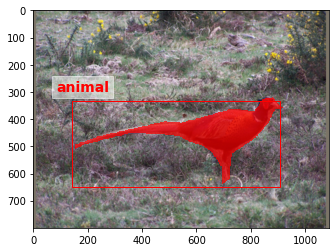

<Figure size 432x288 with 0 Axes>

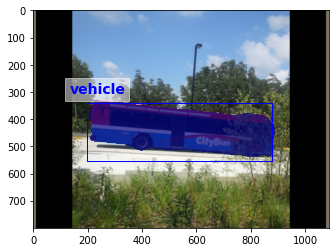

<Figure size 432x288 with 0 Axes>

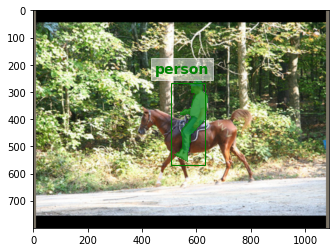

<Figure size 432x288 with 0 Axes>

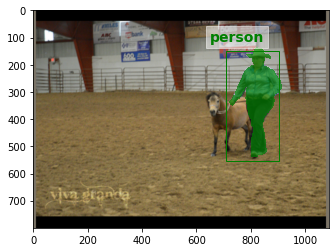

<Figure size 432x288 with 0 Axes>

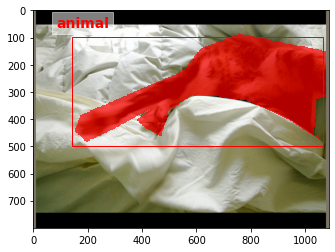

In [23]:
for i, image_data in enumerate(hw_images_data):
    img = image_data["images"][0]
    img = transforms.functional.normalize(img,
                  [-0.485/0.229, -0.456/0.224, -0.406/0.225],
                  [1/0.229, 1/0.224, 1/0.225], inplace=False)
    
    plt.figure()
    fig, ax = plt.subplots(1,1)
    img = img.permute(1,2,0)
    ax.imshow(img)
    for coords, labels, masks in zip(image_data['bboxes'], image_data['labels'], image_data['masks']):
        for c, l, m in zip(coords, labels, masks):
          cmap = ""
          col = ''
          if l == 1:
            cmap = "jet"
            col = 'b'
          elif l == 2:
            col = 'g'
            cmap = "ocean"
          else:
            col = 'r'
            cmap = "prism"
          
          rect=patches.Rectangle((c[0],c[1]),c[2]-c[0],c[3]-c[1],fill=False,color=col)
          ax.add_patch(rect)
          ax.annotate(annotations[l - 1], (c[0] + 40, c[1] - 50), color=col, weight='bold', 
                  fontsize=14, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5,edgecolor="white"))
          
          masked = np.ma.masked_where(m == 0, m)
          
          plt.imshow(masked, cmap, interpolation='none', alpha=0.7)
    plt.savefig(f"results/problem1_{i}")
    plt.show()

In [59]:
model = RPNHead()
model.load_state_dict(torch.load('./model7.pth'))

def plot(ground_coord,gt,images,model,string='ground',i=0,anchors=None):
    fig,ax=plt.subplots(1,1)
    ax.imshow(images.permute(1,2,0))
    if gt.ndim == 1:
      find_cor=(gt==1).nonzero()
    else:
      find_cor=(gt==1).squeeze().nonzero()
    find_neg=(gt==0).squeeze().nonzero()
    for elem in find_cor:
        coord = torch.squeeze(ground_coord[elem,:].view(-1, 4))
        coord[0] = 0 if coord[0]<0 else coord[0]
        coord[1] = 0 if coord[1]<0 else coord[1]
        coord[2] = 800 if coord[0]>800 else coord[2]
        coord[3] = 1088 if coord[3]>1088 else coord[3]
        col='r'
        rect=patches.Rectangle((coord[0],coord[1]),coord[2]-coord[0],coord[3]-coord[1],fill=False,color=col)
        ax.add_patch(rect)
        if anchors is not None:
          anchor=anchors[elem,:]
          rect=patches.Rectangle((anchor[0],anchor[1]),anchor[2]-anchor[0],anchor[3]-anchor[1],fill=False,color='b')
          ax.add_patch(rect)
    plt.show()

for i, batch in enumerate(test_loader):
    images=batch['images'][0,:,:,:]
    indexes=batch['indexes']
    boxes=batch['bboxes']
    # print(boxes)
    # print(batch['labels'])
    #pdb.set_trace()
    # visualise_labels(images.clone(),batch['labels'][0].copy(),batch['masks'][0].clone(),boxes[0].copy())
    gt,ground_coord=model.create_batch_truth(boxes,indexes,images.shape[-2:])

    flatten_coord,flatten_gt,flatten_anchors=output_flattening(ground_coord,gt,model.get_anchors())

    # Decode the ground truth box to get the upper left and lower right corners of the ground truth boxes
    decoded_coord=output_decoding(flatten_coord,flatten_anchors)

    # Plot the image and the anchor boxes with the positive labels and their corresponding ground truth box
    images = transforms.functional.normalize(images,
                                                  [-0.485/0.229, -0.456/0.224, -0.406/0.225],
                                                  [1/0.229, 1/0.224, 1/0.225], inplace=False)
    plot(decoded_coord,flatten_gt,images,model,string='ground',i=i,anchors=flatten_anchors)

    ## Forward
    model.eval()
    cls_out, reg_out = model.forward(batch['images'])
    flatten_coord,flatten_gt,flatten_anchors=output_flattening(reg_out.detach(),cls_out.detach(),model.get_anchors())
    
    # Decode the ground truth box to get the upper left and lower right corners of the ground truth boxes for Part 5
    decoded_coord=output_decoding(flatten_coord,flatten_anchors)

    sort_clas,indices = torch.sort(flatten_gt,dim = 0, descending=True)

    top_proposals = indices[:20]
    top_proposals_clas = sort_clas[:20]

    #print(top_proposals_clas)
    #print(flatten_coord[top_proposals,:])
    top_proposals_clas[top_proposals_clas>0] = 1
    top_proposals_reg = decoded_coord[top_proposals,:]

    #print(top_proposals_reg)
    plot(top_proposals_reg,top_proposals_clas,images,model,string='prediction',i=i)

    # # part 6 inference results
    
    nms_clas_list, nms_prebox_list,pre_nms_clas_list, pre_nms_prebox_list = model.postprocess(cls_out,reg_out,IOU_thresh=0.4)
    nms_clas_list[0][nms_clas_list[0]>0] = 1
    pre_nms_clas_list[0][pre_nms_clas_list[0]>0] = 1
    
    # pdb.set_trace()
    plot(pre_nms_prebox_list[0].squeeze(),pre_nms_clas_list[0],images,model,string='predictionpreNMS',i=i)
    plot(nms_prebox_list[0],nms_clas_list[0],images,model,string='predictionpostNMS',i=i)
    plt.show()

    img = batch["images"][0]
    img = transforms.functional.normalize(img,
                  [-0.485/0.229, -0.456/0.224, -0.406/0.225],
                  [1/0.229, 1/0.224, 1/0.225], inplace=False)
    plt.figure()
    fig, ax = plt.subplots(1,1)
    img = img.permute(1,2,0)
    ax.imshow(img)
    for coords, labels, masks in zip(batch['bboxes'], batch['labels'], batch['masks']):
        for c, l, m in zip(coords, labels, masks):
          cmap = ""
          col = ''
          if l == 1:
            cmap = "jet"
            col = 'b'
          elif l == 2:
            col = 'g'
            cmap = "ocean"
          else:
            col = 'r'
            cmap = "prism"
          
          rect=patches.Rectangle((c[0],c[1]),c[2]-c[0],c[3]-c[1],fill=False,color=col)
          ax.add_patch(rect)
          ax.annotate(annotations[l - 1], (c[0] + 40, c[1] - 50), color=col, weight='bold', 
                  fontsize=14, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5,edgecolor="white"))
          
          masked = np.ma.masked_where(m == 0, m)
          
          plt.imshow(masked, cmap, interpolation='none', alpha=0.7)
    if i > 5:
        break

RuntimeError: ignored

In [ ]:
_import torch.optim as optim

In [ ]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

In [ ]:
rpn_net = RPNHead().to(device)
optimizer = optim.SGD(rpn_net.parameters(),lr = 0.01/batch_size,weight_decay=1.0e-4,momentum=0.90)
epochs = 40
for e in range(epochs):
    batch_loss = 0
    batch_loss_c = 0
    batch_loss_r = 0
    print("Epoch {}".format(e))
    for i, batch in enumerate(train_loader):
        X = batch['images'].to(device)
        images = batch['images'][0,:,:,:]
        indexes = batch['indexes']
        boxes = batch['bboxes']
        gt, ground_coord = rpn_net.create_batch_truth(boxes,indexes,images.shape[-2:]) 
        cls_out, reg_out = rpn_net.forward(X)
        loss, loss_c, loss_r = rpn_net.compute_loss(cls_out, reg_out, gt.to(device), ground_coord.to(device), effective_batch=1000)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_loss +=loss.cpu().item()
        batch_loss_c += loss_c.cpu().item()
        batch_loss_r += loss_r.cpu().item()

        if i % 10 == 0:
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.
                  format(e, i * len(batch['images']), train_size,
                        100. * i / len(train_loader), loss.cpu().item()))
    
    print("Total Loss, Loss Class, Loss R: {} {}  {}".format(batch_loss,batch_loss_c,batch_loss_r))
torch.save(rpn_net.state_dict(), './model2.pth')

Epoch 0


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train Epoch: 0 [0/2612 (0%)]	Loss: 1.698249
